In [ ]:
!pip install pandas seaborn networkx matplotlib numpy kagglehub scikit-learn pgmpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00


In [ ]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BayesianEstimator
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
from pgmpy.inference import VariableElimination, BeliefPropagation
from pgmpy.models import BayesianNetwork

sns.set_theme(style="whitegrid")
%matplotlib inline

In [ ]:
# Baixar o dataset Titanic do Kaggle usando KaggleHub
path = kagglehub.dataset_download("yasserh/titanic-dataset")
data_csv_path = path + "/Titanic-Dataset.csv"

# Carregar os dados em um DataFrame
train_dataset = pd.read_csv(data_csv_path)

# Exibir as primeiras linhas do dataset para uma visão inicial
print("Primeiras linhas do dataset de treinamento:")
print(train_dataset.head())

# Verificar valores ausentes em cada coluna
print("\nValores ausentes por coluna (Treinamento):")
print(train_dataset.isnull().sum())

# Preencher valores ausentes na coluna 'Age' com a mediana da idade
train_dataset['Age'] = train_dataset['Age'].fillna(train_dataset['Age'].median())

# Preencher valores ausentes na coluna 'Embarked' com o valor mais frequente
train_dataset['Embarked'] = train_dataset['Embarked'].fillna(train_dataset['Embarked'].mode()[0])

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes
train_dataset.drop(columns=['Cabin'], inplace=True)

# Converter a coluna 'Sex' de categórica para numérica (0 = male, 1 = female)
train_dataset['Sex'] = train_dataset['Sex'].map({'male': 0, 'female': 1})

# Converter a coluna 'Embarked' de categórica para numérica (S = 0, C = 1, Q = 2)
train_dataset['Embarked'] = train_dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes para o modelo
train_data = train_dataset[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Visualizar as primeiras linhas após o pré-processamento
print("\nDados após o pré-processamento:")
print(train_data.head())

# Verificar valores ausentes após o pré-processamento
print("\nValores ausentes por coluna (Treinamento):")
print(train_data.isnull().sum())

Primeiras linhas do dataset de treinamento:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0   

# **Limpar o DataSet**

In [ ]:
# Exibir as primeiras linhas do dataset para uma visão inicial
print("Primeiras linhas do dataset de treinamento:")
print(train_dataset.head())

# Verificar valores ausentes em cada coluna
print("\nValores ausentes por coluna (Treinamento):")
print(train_dataset.isnull().sum())

# Preencher valores ausentes na coluna 'Age' com a mediana da idade
train_dataset['Age'] = train_dataset['Age'].fillna(train_dataset['Age'].median())

# Preencher valores ausentes na coluna 'Embarked' com o valor mais frequente
train_dataset['Embarked'] = train_dataset['Embarked'].fillna(train_dataset['Embarked'].mode()[0])

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes (se existir)
if 'Cabin' in train_dataset.columns:
    train_dataset = train_dataset.drop(columns=['Cabin'])

# Converter a coluna 'Sex' de categórica para numérica (0 = male, 1 = female)
train_dataset['Sex'] = train_dataset['Sex'].map({'male': 0, 'female': 1})

# Converter a coluna 'Embarked' de categórica para numérica (S = 0, C = 1, Q = 2)
train_dataset['Embarked'] = train_dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes para o modelo
train_data = train_dataset[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Visualizar as primeiras linhas após o pré-processamento
print("\nDados após o pré-processamento:")
print(train_data.head())

# Verificar valores ausentes após o pré-processamento
print("\nValores ausentes por coluna (Treinamento):")
print(train_data.isnull().sum())


Primeiras linhas do dataset de treinamento:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  Embarked  
0         A/5 21171   7.2500         0  
1          PC 17599  71.2833         1  
2  STON/O2. 3101282   7.9250         0  
3            113803  53.1000         0  
4            373450   8.0500         0  

Valor

### Discretizar as colunas 'Age' e 'Fare' para uso na rede bayesiana

In [ ]:
# Preencher valores ausentes em 'Age' e 'Fare' antes de qualquer discretização
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)

# Discretizar a coluna 'Age' em 5 faixas de frequência semelhante (quantile)
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
train_data['Age'] = age_discretizer.fit_transform(train_data[['Age']])

# Discretizar a coluna 'Fare' em 4 faixas (quartis) e garantir a conversão para numérico
train_data['Fare'] = pd.qcut(train_data['Fare'], 4, labels=[0, 1, 2, 3]).astype(float)

# Verificar novamente se há algum valor NaN e preencher com zero
train_data.fillna(0, inplace=True)

# Converter todas as colunas para tipo inteiro, se necessário
train_data = train_data.astype(int)

# Verificar os dados após a discretização e conversão
print("\nDados após a discretização de 'Age' e 'Fare':")
print(train_data.head())



Dados após a discretização de 'Age' e 'Fare':
   Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked
0         0       3    0    0      1      0     0         0
1         1       1    0    0      1      0     3         0
2         1       3    0    0      0      0     1         0
3         1       1    0    0      1      0     3         0
4         0       3    0    0      0      0     1         0


C:\Users\xbea3\AppData\Local\Temp\ipykernel_21192\604276189.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\xbea3\AppData\Local\Temp\ipykernel_21192\604276189.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [ ]:
# Definir as variáveis independentes (X) e a variável alvo (y)
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

# Calcular a mutual information
mi = mutual_info_classif(X, y, discrete_features=True)

# Exibir a importância das variáveis
importance = pd.Series(mi, index=X.columns)
importance.sort_values(ascending=False, inplace=True)
print("Importância das variáveis (Mutual Information):")
print(importance)

Importância das variáveis (Mutual Information):
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Sex         0.000000
Age         0.000000
Embarked    0.000000
dtype: float64


In [ ]:
# Selecionar as 7 variáveis mais importantes com base na Informação Mútua
top_7_features = importance.head(7)
print("\nTop 7 variáveis mais importantes com base na Informação Mútua:")
print(top_7_features)

# Criar uma nova tabela com as 7 variáveis mais importantes + a coluna alvo 'Survived'
top_7_vars = top_7_features.index.tolist()
new_df = train_data[top_7_vars + ['Survived']]

# Exibir as primeiras linhas da nova tabela para verificação
print("\nNova tabela com as 7 variáveis mais importantes e a coluna alvo:")
print(new_df.head())

# Salvar a nova tabela em um arquivo CSV para uso futuro ou compartilhamento (Opcional)
# new_df.to_csv('top_7_features_table.csv', index=False)
# print("Nova tabela salva como 'top_7_features_table.csv'")



Top 7 variáveis mais importantes com base na Informação Mútua:
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Sex         0.000000
Age         0.000000
Embarked    0.000000
dtype: float64

Nova tabela com as 7 variáveis mais importantes e a coluna alvo:
   Pclass  Fare  SibSp  Parch  Sex  Age  Embarked  Survived
0       3     0      1      0    0    0         0         0
1       1     3      1      0    0    0         0         1
2       3     1      0      0    0    0         0         1
3       1     3      1      0    0    0         0         1
4       3     1      0      0    0    0         0         0


In [ ]:
# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = train_test_split(new_df, test_size=0.2, random_state=42, stratify=new_df['Survived'])

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")
print(new_df.head())



Conjunto de Treinamento: 712 registros
Conjunto de Teste: 179 registros
   Pclass  Fare  SibSp  Parch  Sex  Age  Embarked  Survived
0       3     0      1      0    0    0         0         0
1       1     3      1      0    0    0         0         1
2       3     1      0      0    0    0         0         1
3       1     3      1      0    0    0         0         1
4       3     1      0      0    0    0         0         0


In [ ]:
# Definir diferentes configurações para o BayesianEstimator
estimator_configs = [
    {'prior_type': 'BDeu', 'equivalent_sample_size': 1},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 10},
    {'prior_type': 'BDeu', 'equivalent_sample_size': 20},
    # Adicione mais configurações conforme necessário
]

# Lista para armazenar os melhores modelos com diferentes configurações
best_models = []

# Iterar sobre as configurações do estimador
for est_config in estimator_configs:
    # Estimar a estrutura usando o BIC Score
    est_hc = HillClimbSearch(train_data)
    best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))

    # Criar o modelo de rede bayesiana com as arestas encontradas
    model_bic = BayesianNetwork(best_model_bic.edges())

    # Ajustar o modelo com o BayesianEstimator usando a configuração atual
    model_bic.fit(train_data, estimator=BayesianEstimator, prior_type=est_config['prior_type'], equivalent_sample_size=est_config['equivalent_sample_size'])

    # Adicionar o modelo treinado e sua configuração à lista
    best_models.append({
        'model': model_bic,
        'estimator_config': est_config
    })

    # Exibir a configuração atual
    print(f"Modelo BIC treinado com configuração: {est_config}")


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 4/1000000 [00:00<7:26:17, 37.34it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 1}


  0%|          | 4/1000000 [00:00<7:25:28, 37.41it/s]


Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


  0%|          | 4/1000000 [00:00<7:33:29, 36.75it/s]

Modelo BIC treinado com configuração: {'prior_type': 'BDeu', 'equivalent_sample_size': 20}


In [ ]:
# Treinar o modelo usando Hill Climbing com o K2 Score
k2score = K2Score(train_data)
best_model_k2 = HillClimbSearch(train_data).estimate(scoring_method=k2score)

# Criar e treinar o modelo de rede bayesiana com a estrutura K2 encontrada
model_k2 = BayesianNetwork(best_model_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)

print("\nModelo K2 treinado com configuração padrão: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}")


  0%|          | 10/1000000 [00:00<4:15:58, 65.11it/s]


Modelo K2 treinado com configuração padrão: {'prior_type': 'BDeu', 'equivalent_sample_size': 10}


In [ ]:
# Definir a estrutura da rede utilizando Hill Climbing e o critério de BIC Score
hc = HillClimbSearch(train_data)
best_model_bic = hc.estimate(scoring_method=BicScore(train_data))

# Criar o modelo bayesiano usando a estrutura obtida
model_bic_trained = BayesianNetwork(best_model_bic.edges())
model_bic_trained.fit(train_data, estimator=BayesianEstimator)

# Imprimir as CPDs da Rede Bayesian treinada com BIC Score
print("\nTabelas de Probabilidade Condicional (CPDs) - BIC Score:")
for cpd in model_bic_trained.get_cpds():
    print(cpd)

# Definir a estrutura da rede utilizando Hill Climbing e o critério de K2 Score
best_model_k2 = hc.estimate(scoring_method=K2Score(train_data))

# Criar o modelo bayesiano usando a estrutura obtida
model_k2 = BayesianNetwork(best_model_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator)

# Imprimir as CPDs da Rede Bayesian treinada com K2 Score
print("\nTabelas de Probabilidade Condicional (CPDs) - K2 Score:")
for cpd in model_k2.get_cpds():
    print(cpd)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 4/1000000 [00:00<7:19:42, 37.90it/s]



Tabelas de Probabilidade Condicional (CPDs) - BIC Score:
+-----------+----------+
| Pclass(1) | 0.240818 |
+-----------+----------+
| Pclass(2) | 0.21153  |
+-----------+----------+
| Pclass(3) | 0.547652 |
+-----------+----------+
+---------+----------------------+---------------------+---------------------+
| Pclass  | Pclass(1)            | Pclass(2)           | Pclass(3)           |
+---------+----------------------+---------------------+---------------------+
| Fare(0) | 0.03716216216216216  | 0.04230769230769231 | 0.42890492359932086 |
+---------+----------------------+---------------------+---------------------+
| Fare(1) | 0.002413127413127413 | 0.45109890109890116 | 0.2888370118845501  |
+---------+----------------------+---------------------+---------------------+
| Fare(2) | 0.23986486486486483  | 0.3851648351648352  | 0.1946095076400679  |
+---------+----------------------+---------------------+---------------------+
| Fare(3) | 0.7205598455598455   | 0.12142857142857144 |

  0%|          | 10/1000000 [00:00<3:57:57, 70.04it/s]


Tabelas de Probabilidade Condicional (CPDs) - K2 Score:
+-----------+----------+
| Pclass(1) | 0.240818 |
+-----------+----------+
| Pclass(2) | 0.21153  |
+-----------+----------+
| Pclass(3) | 0.547652 |
+-----------+----------+
+----------+-----------------------+-----+-------------+
| Parch    | Parch(0)              | ... | Parch(6)    |
+----------+-----------------------+-----+-------------+
| Pclass   | Pclass(1)             | ... | Pclass(3)   |
+----------+-----------------------+-----+-------------+
| Survived | Survived(0)           | ... | Survived(1) |
+----------+-----------------------+-----+-------------+
| Fare(0)  | 0.12275811924381969   | ... | 0.25        |
+----------+-----------------------+-----+-------------+
| Fare(1)  | 0.0006059137178865729 | ... | 0.25        |
+----------+-----------------------+-----+-------------+
| Fare(2)  | 0.346703829374697     | ... | 0.25        |
+----------+-----------------------+-----+-------------+
| Fare(3)  | 0.529932137663

In [ ]:
# Definir a estrutura do modelo Bayesian para garantir inclusão de todas as variáveis
model_structure = [
    ('Pclass', 'Survived'),
    ('Sex', 'Survived'),
    ('Age', 'Survived')
]

# Criar e configurar o modelo com a estrutura definida
model_bic = BayesianNetwork(model_structure)
model_bic.fit(train_data, estimator=BayesianEstimator)

# Inicializar o objeto de inferência
inference = VariableElimination(model_bic)

# Definir as combinações de valores para Pclass, Sex e Age usando apenas estados conhecidos (0 e 1 para Sex, etc.)
combinations = [
    {'Pclass': 1, 'Sex': 1, 'Age': 0},
    {'Pclass': 1, 'Sex': 1, 'Age': 1},
    {'Pclass': 1, 'Sex': 0, 'Age': 0},
    {'Pclass': 1, 'Sex': 0, 'Age': 1},
    {'Pclass': 2, 'Sex': 1, 'Age': 0},
    {'Pclass': 2, 'Sex': 1, 'Age': 1},
    {'Pclass': 2, 'Sex': 0, 'Age': 0},
    {'Pclass': 2, 'Sex': 0, 'Age': 1},
    {'Pclass': 3, 'Sex': 1, 'Age': 0},
    {'Pclass': 3, 'Sex': 1, 'Age': 1},
    {'Pclass': 3, 'Sex': 0, 'Age': 0},
    {'Pclass': 3, 'Sex': 0, 'Age': 1}
]

# Lista para armazenar os resultados
results = []

# Calcular P(Survived=1 | Pclass, Sex, Age) para cada combinação
for combo in combinations:
    try:
        prob = inference.query(variables=['Survived'], evidence=combo)
        survived_prob = prob.values[1]  # P(Survived=1)
        results.append({**combo, 'P(Survived=1)': survived_prob})
    except KeyError as e:
        print(f"Erro de chave não encontrada: {e} para combinação {combo}")

# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibir a tabela com os resultados
print(results_df)


Erro de chave não encontrada: 1 para combinação {'Pclass': 1, 'Sex': 1, 'Age': 0}
Erro de chave não encontrada: 1 para combinação {'Pclass': 1, 'Sex': 1, 'Age': 1}
Erro de chave não encontrada: 1 para combinação {'Pclass': 1, 'Sex': 0, 'Age': 1}
Erro de chave não encontrada: 1 para combinação {'Pclass': 2, 'Sex': 1, 'Age': 0}
Erro de chave não encontrada: 1 para combinação {'Pclass': 2, 'Sex': 1, 'Age': 1}
Erro de chave não encontrada: 1 para combinação {'Pclass': 2, 'Sex': 0, 'Age': 1}
Erro de chave não encontrada: 1 para combinação {'Pclass': 3, 'Sex': 1, 'Age': 0}
Erro de chave não encontrada: 1 para combinação {'Pclass': 3, 'Sex': 1, 'Age': 1}
Erro de chave não encontrada: 1 para combinação {'Pclass': 3, 'Sex': 0, 'Age': 1}
   Pclass  Sex  Age  P(Survived=1)
0       1    0    0       0.647683
1       2    0    0       0.447253
2       3    0    0       0.244058


In [ ]:
# Estrutura do modelo bayesiano
model_structure = [
    ('Pclass', 'Survived'),
    ('Sex', 'Survived'),
    ('Age', 'Survived'),
    ('Fare', 'Survived'),
    ('Embarked', 'Survived')
]

# Definir o modelo com a estrutura
model_bic = BayesianNetwork(model_structure)

# Ajustar o modelo nos dados com estimador Bayesiano
model_bic.fit(train_data, estimator=BayesianEstimator)

# Definir os estados explicitamente para correspondência correta
for cpd in model_bic.get_cpds():
    print(cpd)

# Inicializar o objeto de inferência
inference_bic = VariableElimination(model_bic)

# Configurar a evidência com valores compatíveis com o modelo
evidence = {'Pclass': 1, 'Sex': 1, 'Fare': 3}  # Ajustar os valores de acordo com os estados que o modelo entende

# Realizar a inferência
try:
    result = inference_bic.query(variables=['Survived'], evidence=evidence)
    print("Resultado da inferência para P(Survived=1 | Pclass=1, Sex=1, Fare=3):")
    print(result)
except KeyError as e:
    print("Erro durante a inferência:", e)


+-----------+----------+
| Pclass(1) | 0.240818 |
+-----------+----------+
| Pclass(2) | 0.21153  |
+-----------+----------+
| Pclass(3) | 0.547652 |
+-----------+----------+
+-------------+---------------------+-----+---------------------+
| Age         | Age(0)              | ... | Age(0)              |
+-------------+---------------------+-----+---------------------+
| Embarked    | Embarked(0)         | ... | Embarked(0)         |
+-------------+---------------------+-----+---------------------+
| Fare        | Fare(0)             | ... | Fare(3)             |
+-------------+---------------------+-----+---------------------+
| Pclass      | Pclass(1)           | ... | Pclass(3)           |
+-------------+---------------------+-----+---------------------+
| Sex         | Sex(0)              | ... | Sex(0)              |
+-------------+---------------------+-----+---------------------+
| Survived(0) | 0.9675324675324676  | ... | 0.7615012106537531  |
+-------------+------------------

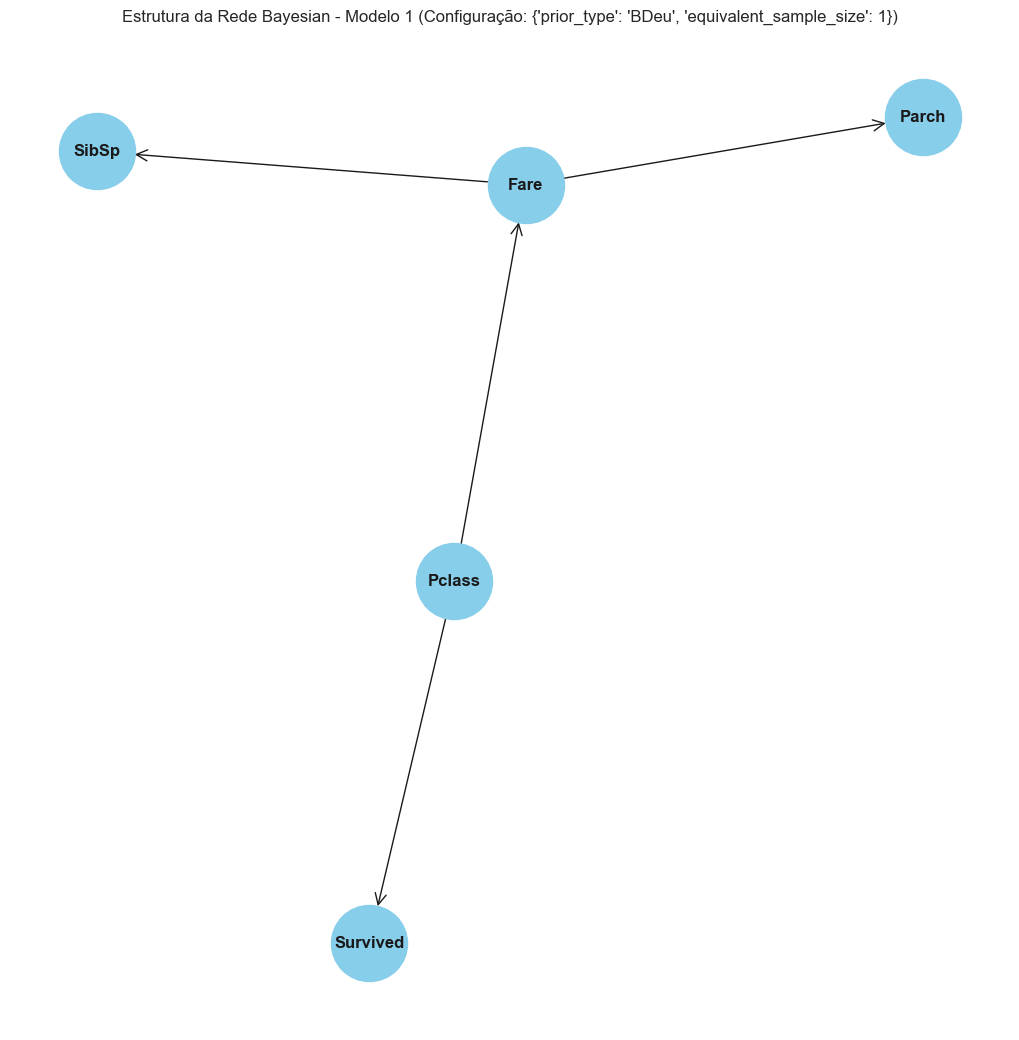

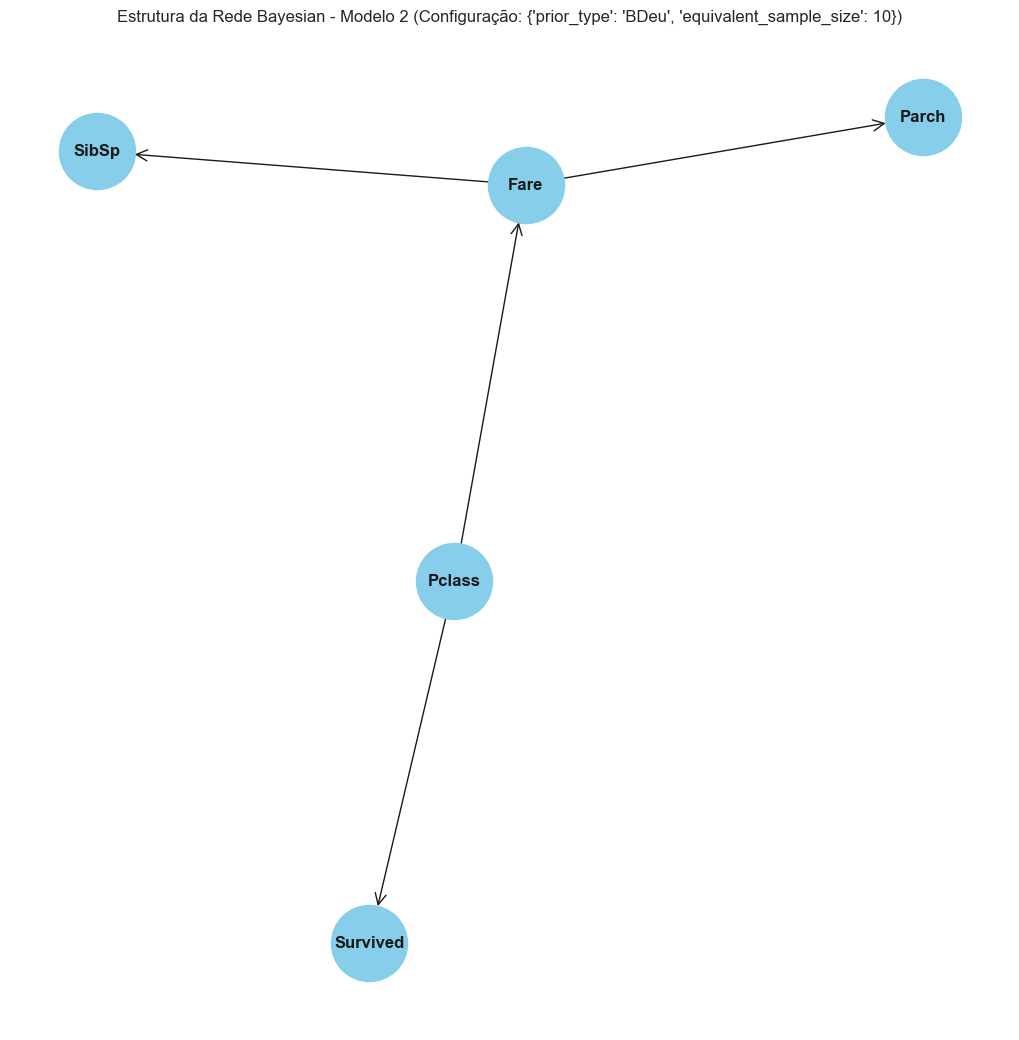

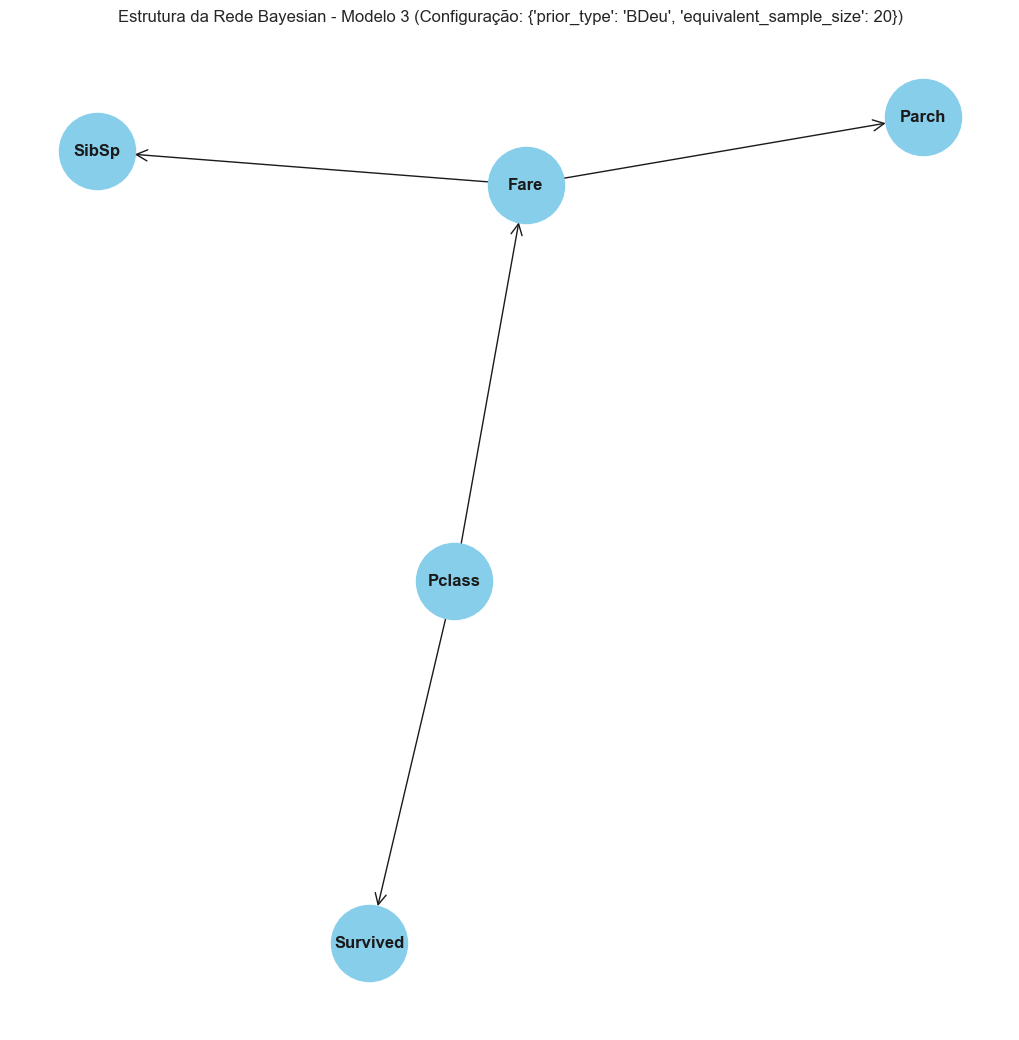

In [ ]:
# Iterar sobre todos os modelos treinados e plotar suas estruturas
for idx, model_info in enumerate(best_models):
    model = model_info['model']
    config = model_info['estimator_config']

    plt.figure(figsize=(10, 10))
    G = nx.DiGraph(model.edges())
    pos = nx.spring_layout(G, seed=42, k=1)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue",
            font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
    plt.title(f"Estrutura da Rede Bayesian - Modelo {idx+1} (Configuração: {config})")
    plt.show()


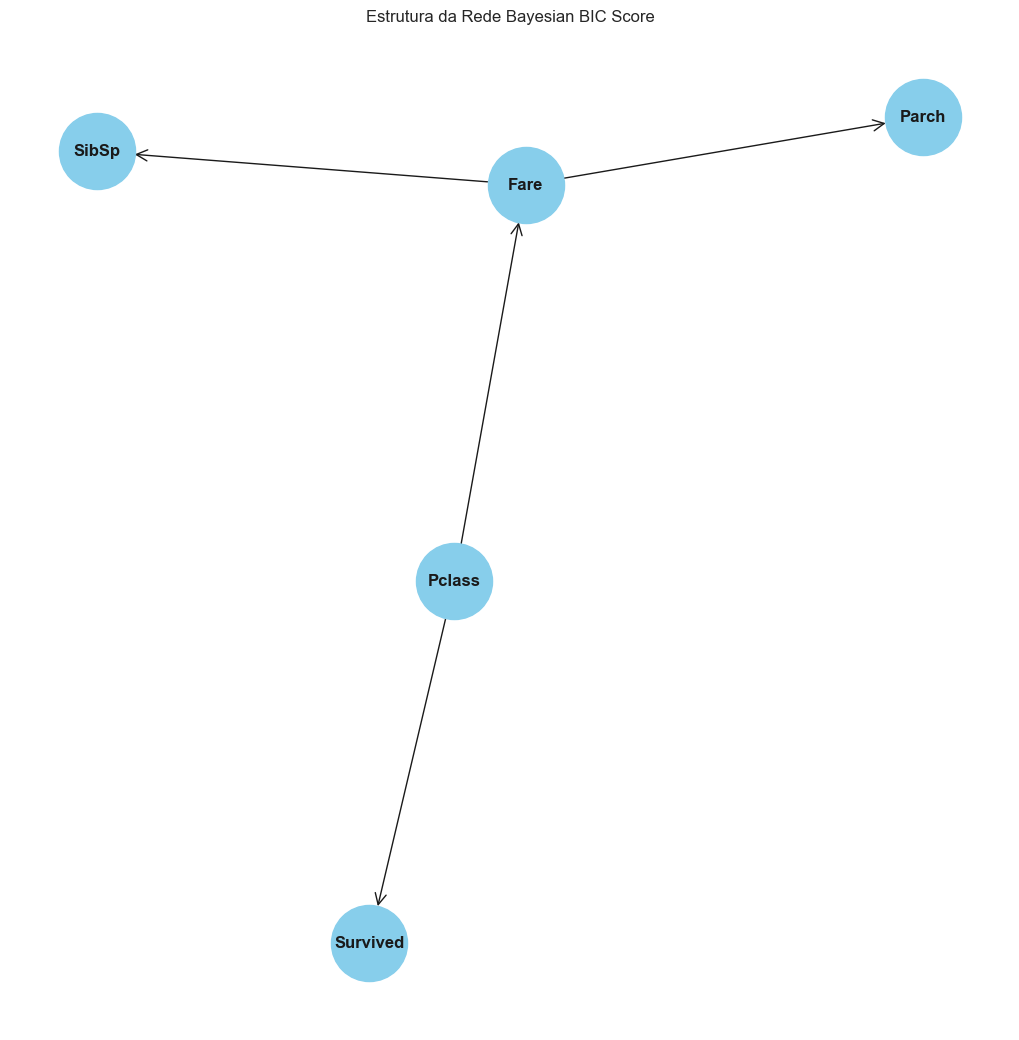

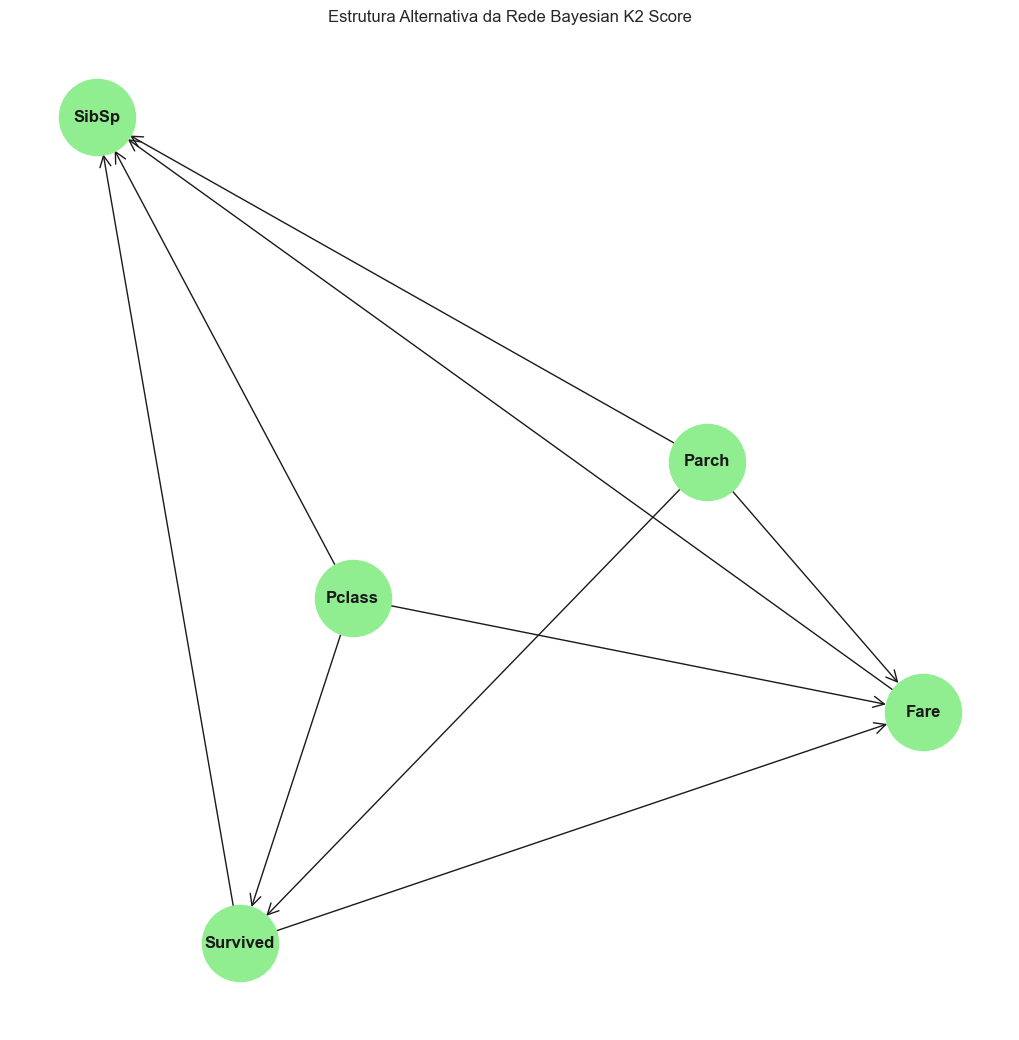

In [ ]:
# Plotar a estrutura da Rede Bayesiana usando BIC Score
plt.figure(figsize=(10, 10))
G_bic = nx.DiGraph(model_bic_trained.edges())
pos_bic = nx.spring_layout(G_bic, seed=42, k=1)  # Ajuste o parâmetro 'k' para melhor visualização
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Estrutura da Rede Bayesian BIC Score")
plt.show()

# Plotar a estrutura da Rede Bayesiana usando K2 Score
plt.figure(figsize=(10, 10))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42, k=1)  # Ajuste o parâmetro 'k' para melhor visualização
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Estrutura Alternativa da Rede Bayesian K2 Score")
plt.show()


In [ ]:
# Função para realizar predições usando inferência nas redes bayesianas
def predict(model, data, evidence_vars, target_var='Survived'):
    inference = VariableElimination(model)
    predictions = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
        except Exception as e:
            predictions.append(0)  # Valor padrão em caso de erro
    return predictions

# Definir as variáveis de evidência
evidence_vars = top_7_vars  # As 7 variáveis selecionadas

# Avaliar o modelo BIC (último modelo treinado na lista best_models)
model_bic_trained = best_models[-1]['model']
predictions_bic = predict(model_bic_trained, test_data, evidence_vars)
accuracy_bic = accuracy_score(test_data['Survived'], predictions_bic)
print(f"\nAcurácia do Modelo BIC no Conjunto de Teste: {accuracy_bic:.4f}")

# Avaliar o modelo K2
predictions_k2 = predict(model_k2, test_data, evidence_vars)
accuracy_k2 = accuracy_score(test_data['Survived'], predictions_k2)
print(f"Acurácia do Modelo K2 no Conjunto de Teste: {accuracy_k2:.4f}")



Acurácia do Modelo BIC no Conjunto de Teste: 0.6145
Acurácia do Modelo K2 no Conjunto de Teste: 0.6145


C:\Users\xbea3\AppData\Local\Temp\ipykernel_21192\1254514287.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bic_labels, y=bic_accuracies, palette="viridis")


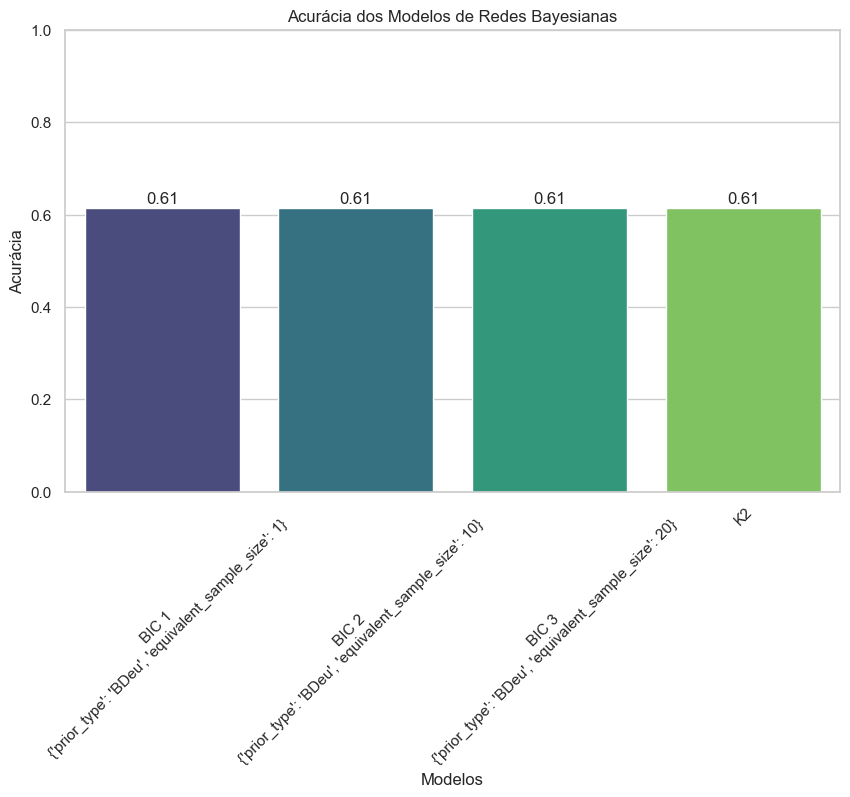

In [ ]:
# Coletar as acurácias dos modelos BIC
bic_accuracies = []
bic_labels = []
for idx, model_info in enumerate(best_models):
    model = model_info['model']
    config = model_info['estimator_config']
    predictions = predict(model, test_data, evidence_vars)
    accuracy = accuracy_score(test_data['Survived'], predictions)
    bic_accuracies.append(accuracy)
    bic_labels.append(f"BIC {idx+1}\n{config}")

# Acurácia do modelo K2
bic_accuracies.append(accuracy_k2)
bic_labels.append("K2")

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=bic_labels, y=bic_accuracies, palette="viridis")
plt.ylim(0, 1)
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.title('Acurácia dos Modelos de Redes Bayesianas')
plt.xticks(rotation=45)
for index, value in enumerate(bic_accuracies):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


In [6]:
def maior_repeticao(dna):
    max_count = 1
    count = 1
    
    # Itera pela string a partir do segundo caractere
    for i in range(1, len(dna)):
        if dna[i] == dna[i - 1]:
            # Se o caractere for igual ao anterior, incrementa o contador
            count += 1
        else:
            # Se o caractere for diferente, reseta o contador
            count = 1
        # Atualiza o comprimento máximo da sequência
        max_count = max(max_count, count)
    
    return max_count

# Leitura da entrada
dna = input().strip()

# Chama a função e imprime o resultado
print(maior_repeticao(dna))


3
